# Tutorial 00: Drivability Checker - Getting Started

This tutorial gives you a quick overview over the basic functionalities of the CommonRoad drivability checker toolbox.
Please make sure you have gone through the tutorials for **CommonRoad Input-Output** beforehand.

The drivability checker toolbox offers three main functions for checking the planned trajectory of the ego vehicle:

* **collision checking**: ensures that the planned trajectory does not collide with other obstacles
* **road-compliance**: ensures that the planned trajectory does not leave the road boundaries
* **kinematic feasibility**: ensures that the planned motion can be executed by a specified vehicle model

In the following sections, we provide a basic demonstration on how to perform these three checks for a simple scenario.

For a more detailed description of these functions, please check out the **advanced tutorials 02-05**.



## Load CommonRoad scenario

/home/gerald/anaconda3/envs/commonroad1/lib/python3.7/site-packages/commonroad/common/reader/file_reader_xml.py:1344: UserWarning: State at time step 1 cannot be matched!
  warnings.warn("State at time step {} cannot be matched!".format(read_time(xml_node.find('time'))))
/home/gerald/anaconda3/envs/commonroad1/lib/python3.7/site-packages/commonroad/common/reader/file_reader_xml.py:1344: UserWarning: State at time step 2 cannot be matched!
  warnings.warn("State at time step {} cannot be matched!".format(read_time(xml_node.find('time'))))
/home/gerald/anaconda3/envs/commonroad1/lib/python3.7/site-packages/commonroad/common/reader/file_reader_xml.py:1344: UserWarning: State at time step 3 cannot be matched!
  warnings.warn("State at time step {} cannot be matched!".format(read_time(xml_node.find('time'))))
/home/gerald/anaconda3/envs/commonroad1/lib/python3.7/site-packages/commonroad/common/reader/file_reader_xml.py:1344: UserWarning: State at time step 4 cannot be matched!
  warnings.wa

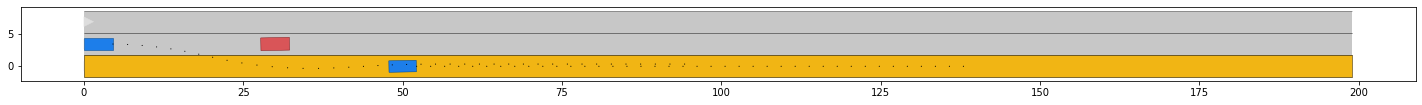

In [1]:
from commonroad.common.file_reader import CommonRoadFileReader
from commonroad.visualization.mp_renderer import MPRenderer

scenario, planning_problem_set = CommonRoadFileReader('ZAM_Tutorial-1_2_T-1.xml').open()
planning_problem = list(planning_problem_set.planning_problem_dict.values())[0]

# plot the scenario
rnd = MPRenderer(figsize=(25, 10))
rnd.draw_params.time_begin = 0
scenario.draw(rnd)
planning_problem.draw(rnd)
artists = rnd.render()


## Create ego vehicle trajectory
We create an exemplary trajectory for our ego vehicle. This trajectory can be computed by any motion planner.
Here, we load a simple trajectory, which we have generated with a planner beforehand and stored as a numpy array. (see
also **commonroad-io Tutorial 2** for more details).

In [2]:
import numpy as np
from commonroad.geometry.shape import Rectangle
from commonroad.scenario.trajectory import Trajectory
from commonroad.scenario.state import CustomState
from commonroad.prediction.prediction import TrajectoryPrediction
from commonroad.scenario.obstacle import DynamicObstacle, ObstacleType


# load precomputed numpy trajectory and get positions and velocities
traj = np.load('ZAM_Tutorial-1_2_T-1_ExampleTrajectory.npz')
s_ego = traj['s_ego']
v_ego = traj['v_ego']


# create Ego Vehicle state list
initial_state = planning_problem.initial_state
state_list = [initial_state]
orientation = initial_state.orientation
for i in range(1, 40):
    # add new state to state_list
    state_list.append(CustomState(**{'position': np.array([s_ego[i],0]), 'orientation': orientation, 'time_step': i,
                               'velocity': v_ego[i]*np.cos(orientation), 'velocity_y': v_ego[i]*np.sin(orientation)}))


# create Ego Vehicle trajectory from state list
ego_vehicle_trajectory = Trajectory(initial_time_step=1, state_list=state_list[1:])
ego_vehicle_shape = Rectangle(length=4.569, width=1.844)
ego_vehicle_prediction = TrajectoryPrediction(trajectory=ego_vehicle_trajectory, shape=ego_vehicle_shape)


# create Ego Vehicle obstacle from trajectory
ego_vehicle = DynamicObstacle(obstacle_id=100, obstacle_type=ObstacleType.CAR, obstacle_shape=ego_vehicle_shape,
                              initial_state=initial_state, prediction=ego_vehicle_prediction)


## Collision Checking
To check if the ego vehicle collides, we create collision objects for all obstacles and the ego vehicle. The scenario
can directly be converted into a collision checker object, which automatically converts all obstacles to collision objects.

In [3]:
from commonroad_dc.collision.collision_detection.pycrcc_collision_dispatch import create_collision_checker, create_collision_object

# create collision checker from scenario
cc = create_collision_checker(scenario)

# create ego vehicle collision object
ego_vehicle_co = create_collision_object(ego_vehicle)

# check if ego vehicle collides
res = cc.collide(ego_vehicle_co)
print('Collision between the ego vehicle and other static/dynamic obstacles: %s' % res)


Collision between the ego vehicle and other static/dynamic obstacles: False


## Road-compliance
Next, we check if our planned trajectory is road-compliant, i.e., it shall not leave the road boundaries. Our toolbox offers
efficient functions to create road boundaries. Using the above method, we can simply check whether the ego vehicle collides
with the road boundary.

In [4]:
from commonroad_dc.boundary.boundary import create_road_boundary_obstacle

# create the road boundary
_, road_boundary = create_road_boundary_obstacle(scenario)

# add road boundary to collision checker
cc.add_collision_object(road_boundary)

# Again: check if ego vehicle collides
res = cc.collide(ego_vehicle_co)
print('Collision between the ego vehicle and the road boundary: %s' % res)



Collision between the ego vehicle and the road boundary: False


## Kinematic feasibility
Finally, we check whether the planned trajectory is kinematically feasible, i.e., if the planned motion can be executed
by a specified vehicle model. Our feasibility checker first reconstructs
the input vector for the planned trajectory and then reconstructs the trajectory via forward simulation of the
given vehicle model. If the error between original and reconstructed trajectory lie within a specified error margin,
the trajectory is feasible.

In [5]:
import commonroad_dc.feasibility.feasibility_checker as feasibility_checker
from commonroad_dc.feasibility.vehicle_dynamics import VehicleDynamics, VehicleType

# set time step as scenario time step
dt = scenario.dt

# choose vehicle model (here kinematic single-track model)
vehicle_dynamics = VehicleDynamics.KS(VehicleType.BMW_320i)

# check feasibility of planned trajectory for the given vehicle model
feasible, reconstructed_inputs = feasibility_checker.trajectory_feasibility(ego_vehicle_trajectory, vehicle_dynamics, dt)
print('The planned trajectory is feasible: %s' % feasible)


The planned trajectory is feasible: True


## Visualization of planned motion
To validate our checking results, we visualize the scenario. We can see
that the ego vehicle (green) does not collide with the static (red) and dynamic (blue) obstacles and does not leave
the road network.

/home/gerald/anaconda3/envs/commonroad1/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


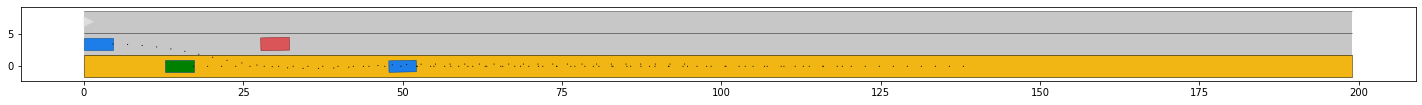

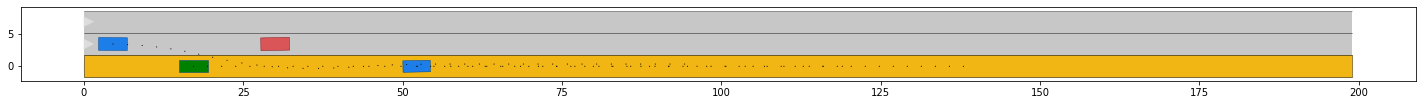

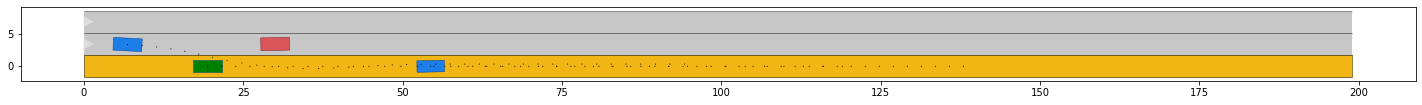

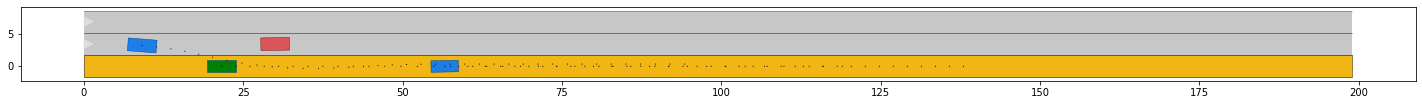

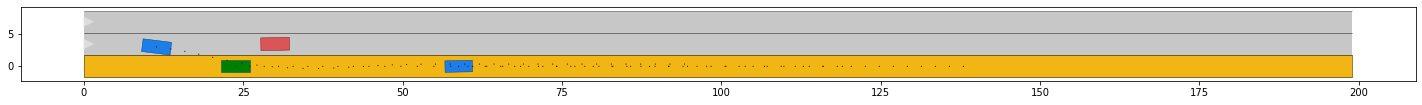

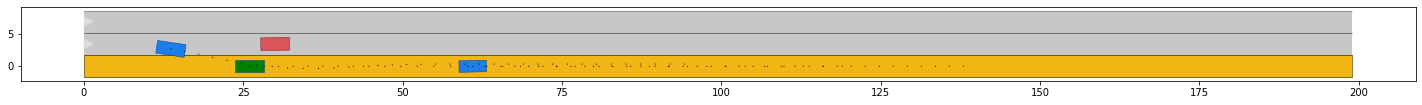

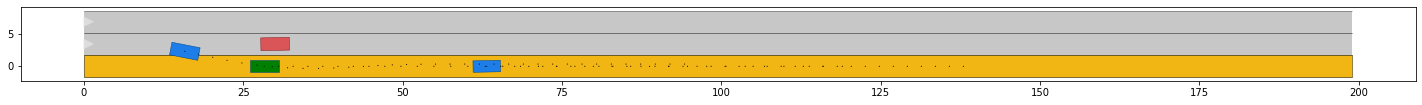

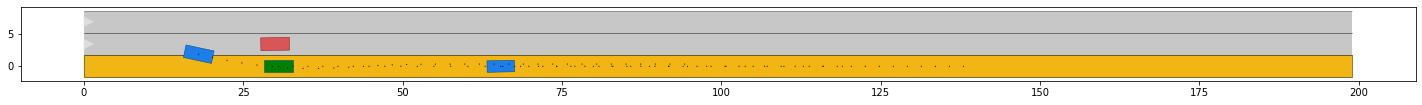

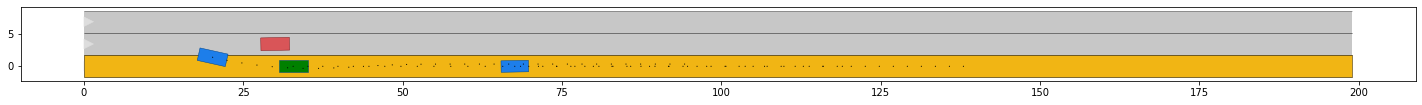

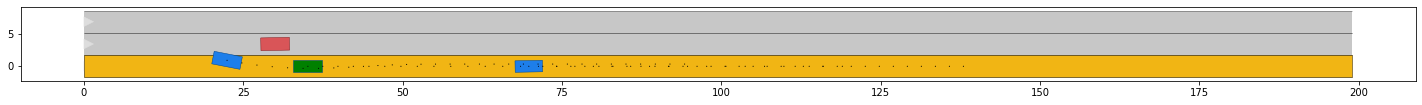

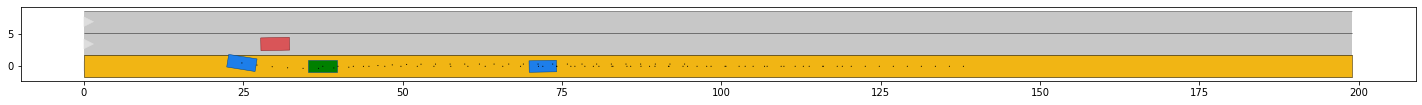

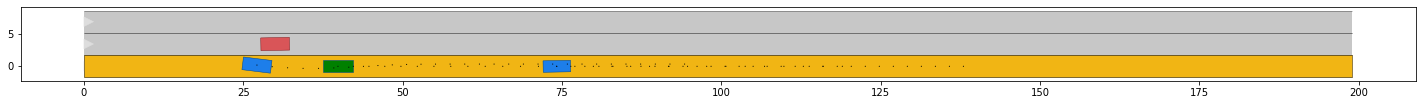

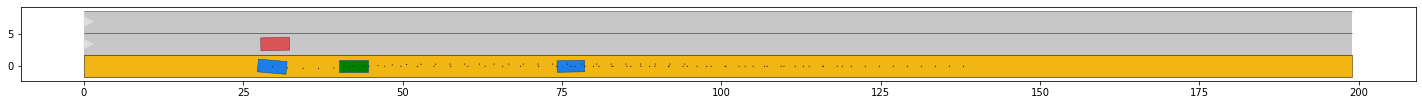

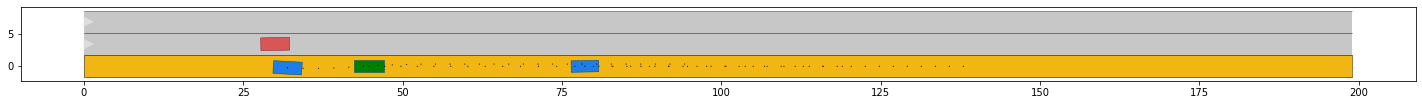

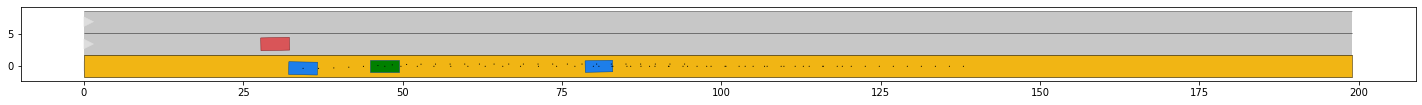

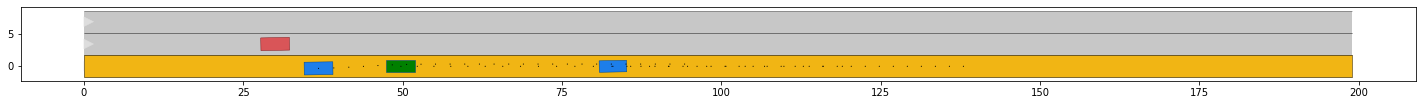

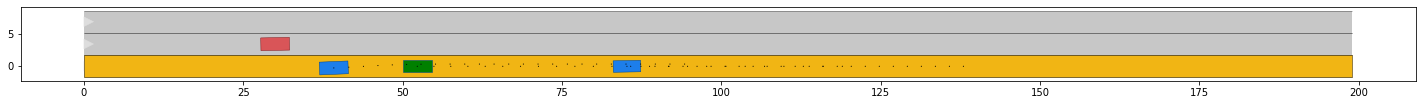

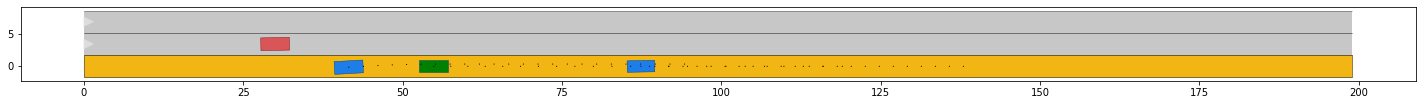

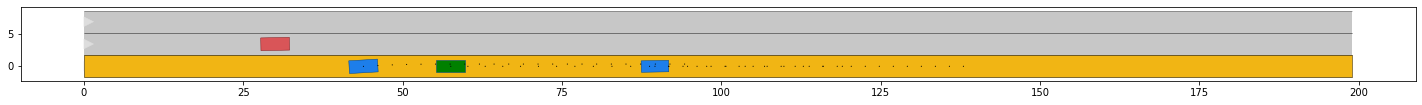

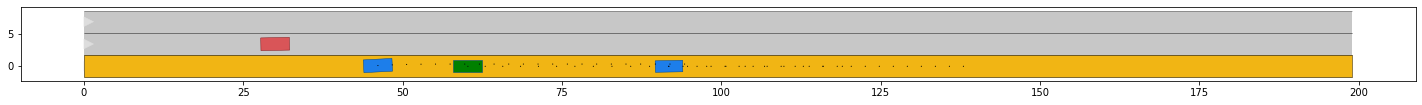

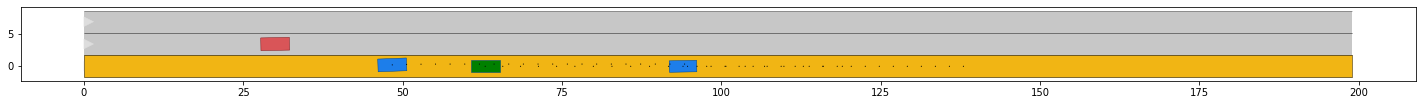

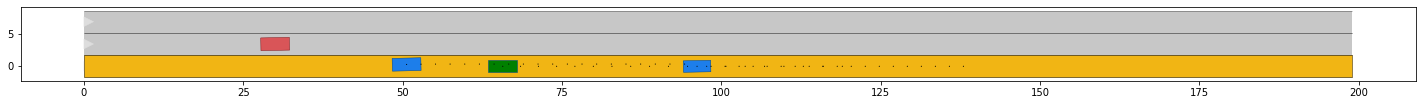

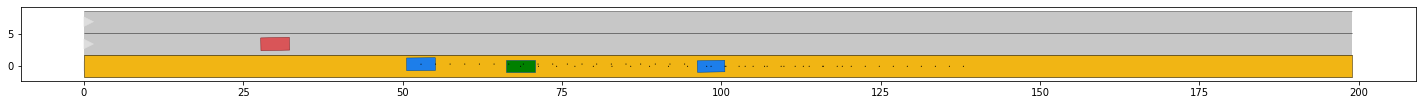

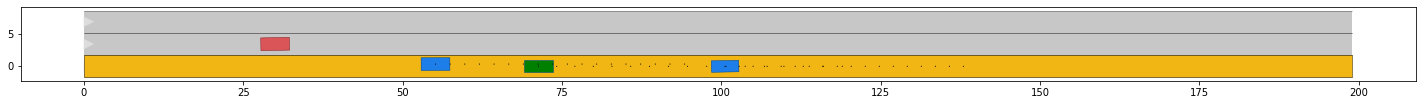

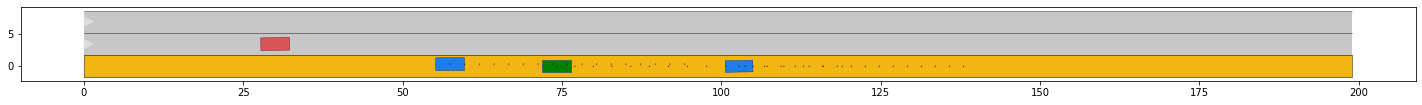

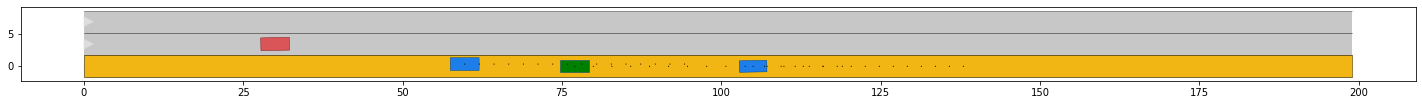

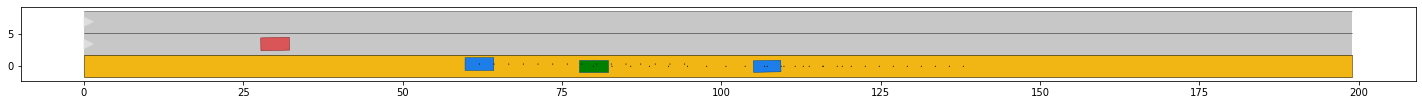

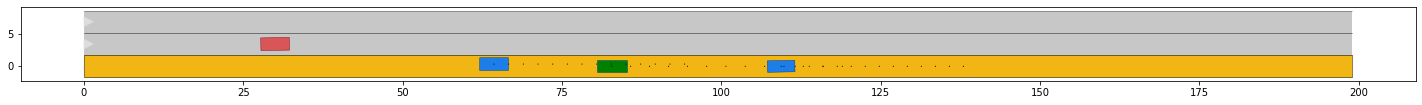

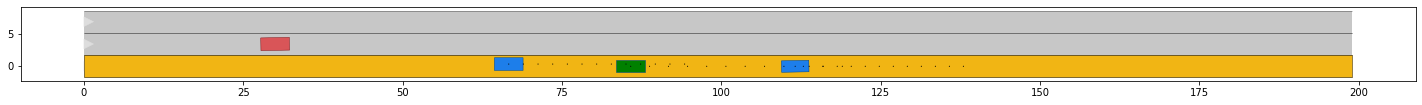

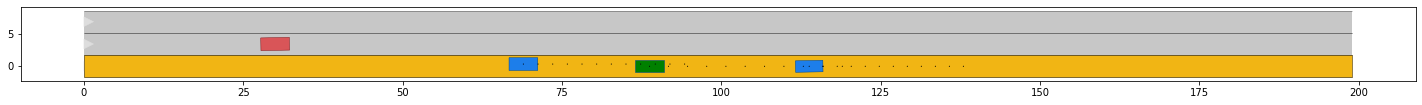

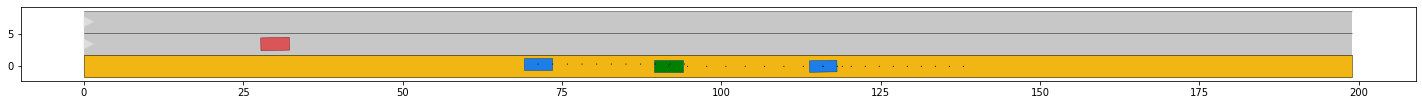

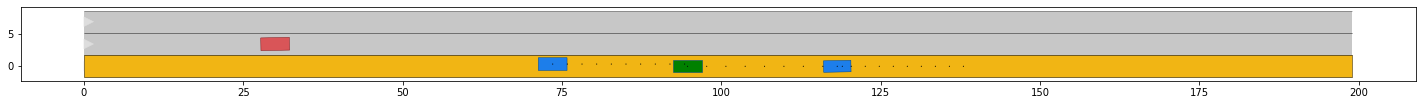

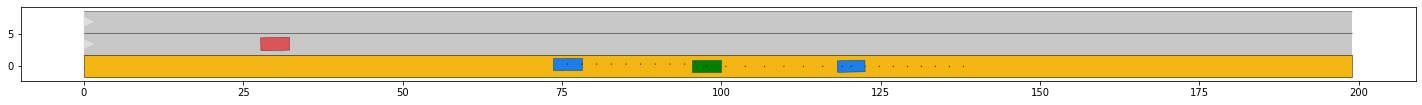

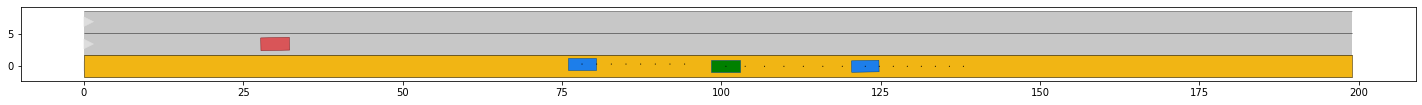

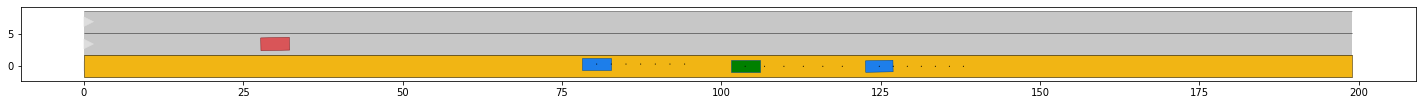

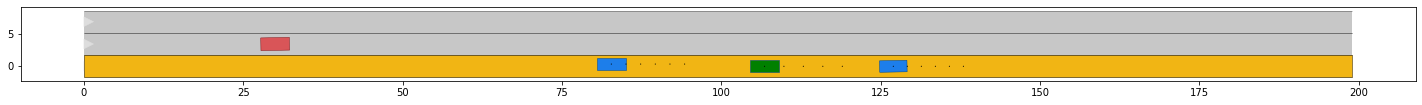

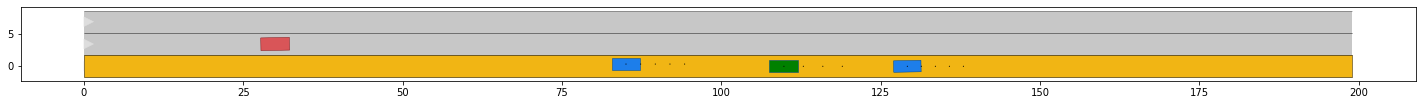

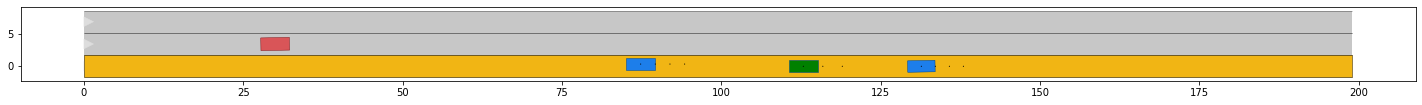

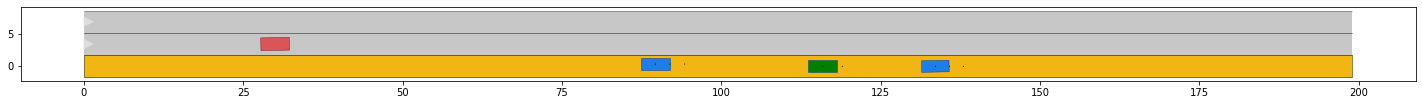

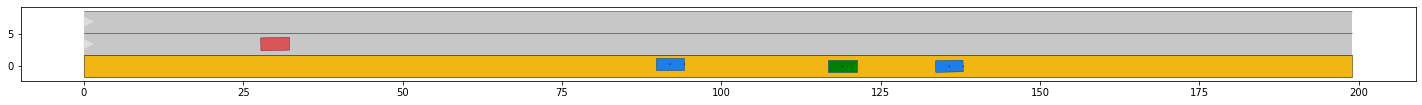

In [6]:
import matplotlib.pyplot as plt
# plot the scenario and the ego vehicle for each time step
for i in range(0, 40):
    plt.figure(figsize=(25, 10))
    rnd = MPRenderer()
    rnd.draw_params.time_begin = i
    scenario.draw(rnd)
    rnd.draw_params.dynamic_obstacle.vehicle_shape.occupancy.shape.facecolor = "g"
    ego_vehicle.draw(rnd)
    planning_problem_set.draw(rnd)
    rnd.render()